In [1]:
import os
import sys

sys.path.append('../synax/')

import synax
import jax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
key = jax.random.key(42)
B_key,C_key =jax.random.split(key)
B_field = jax.random.normal(B_key,(512,512,256),)
C_field = jax.random.normal(C_key,(512,512,256),)

2024-06-20 16:37:48.565798: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
@jax.jit
def C_page(x:float,y:float,z:float,C0:float = 6.4e-5,hr:float=5,hd:float=1):
    return C0*jnp.exp(-jnp.sqrt(x**2+y**2)/hr)/jnp.cosh(z/hd)**2

C_page_vmap = jax.vmap(lambda x,y,z:C_page(x,y,z))

'''def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):
    r = jnp.sqrt(x**2+y**2)
    phi = jnp.atan2(x,y)
    psi_r = psi_0+psi_1*jnp.log()
    return '''

'def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):\n    r = jnp.sqrt(x**2+y**2)\n    phi = jnp.atan2(x,y)\n    psi_r = psi_0+psi_1*jnp.log()\n    return '

In [4]:
xs = jnp.linspace(-20,20,256)
ys = jnp.linspace(-20,20,256)
zs = jnp.linspace(-5,5,64)

In [5]:
coords = jnp.meshgrid(xs,ys,zs)

In [6]:
%%time
C_field = C_page_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
C_field = C_field.reshape((256,256,64))

CPU times: user 72.8 ms, sys: 0 ns, total: 72.8 ms
Wall time: 91.5 ms


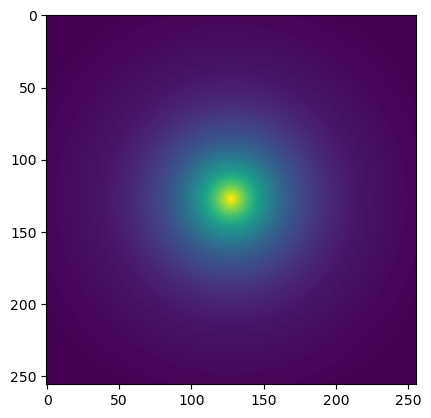

In [7]:
plt.imshow(C_field[:,:,32])

In [8]:
dtype = np.float64  # 32-bit floating point

# Read the binary file
breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3))
brnd = np.fromfile('../../SyncEmiss/brnd.bin', dtype=dtype).reshape((256,256,64,3))

In [9]:
B_field = jnp.array(breg+brnd)
B_field_square = (B_field**2).sum(axis=-1)

In [40]:
def obtain_nhat(x:float,y:float,z:float,obs_coord:tuple[float] = (-8.3,0.,0.06)):
    x_rel = x - obs_coord[0]
    y_rel = y - obs_coord[1]
    z_rel = z - obs_coord[2]
    r = (x_rel**2+y_rel**2+z_rel**2)**0.5
    return jnp.array([x_rel,y_rel,z_rel])/r

obtain_nhat_vamp = jax.vmap(lambda x,y,z:obtain_nhat(x,y,z))

In [41]:
nhats = obtain_nhat_vamp(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
nhats = nhats.reshape((256,256,64,3))

In [42]:
B_los_square = ((nhats*B_field)**2).sum(axis=-1)

In [43]:
B_trans = (B_field_square-B_los_square+1e-12)**0.5

In [44]:
%%time
emiss = synax.sync_emiss_I(1,B_trans,C_field)

CPU times: user 77 µs, sys: 54 µs, total: 131 µs
Wall time: 151 µs


In [45]:
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi))

In [46]:
nside = 256
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)

theta.shape


(786432,)

In [47]:
poss = obtain_vmap(theta,phi)

In [48]:
x_pos = poss[:,0].reshape(-1)
y_pos = poss[:,1].reshape(-1)
z_pos = poss[:,2].reshape(-1)
poss[:,0].shape

(786432, 256)

In [49]:
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))

In [50]:
%%time
Sync_interp = interp_3d(poss)
Sync_int = Sync_interp.sum(axis=-1)

CPU times: user 221 ms, sys: 0 ns, total: 221 ms
Wall time: 219 ms


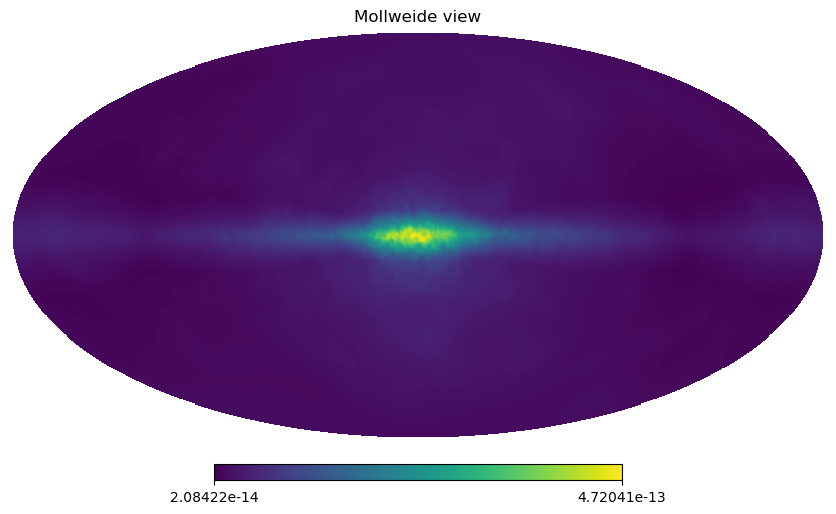

In [51]:
hp.mollview(Sync_int)

In [33]:
B_trans.min()

Array(nan, dtype=float32)

In [52]:
(nhats**2).sum(axis=-1)

Array([[[1.        , 1.        , 0.9999998 , ..., 0.99999994,
         1.        , 0.9999999 ],
        [1.        , 0.9999998 , 0.9999999 , ..., 0.99999994,
         0.99999994, 0.99999976],
        [1.0000001 , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        ...,
        [1.        , 1.0000001 , 1.        , ..., 0.99999994,
         1.0000001 , 1.        ],
        [1.        , 1.        , 0.9999999 , ..., 1.        ,
         1.        , 0.99999994],
        [1.        , 1.0000001 , 1.        , ..., 1.        ,
         0.99999994, 1.0000001 ]],

       [[1.0000001 , 1.        , 0.9999999 , ..., 1.        ,
         1.        , 1.0000001 ],
        [1.        , 1.        , 1.0000001 , ..., 1.        ,
         0.99999994, 1.        ],
        [1.        , 0.99999994, 1.        , ..., 1.0000001 ,
         1.0000001 , 1.        ],
        ...,
        [1.        , 0.9999999 , 1.        , ..., 1.        ,
         1.0000001 , 1.        ],
        [1.0